# att2Conv-batch

这里我们将`the quick brown fox jumped over the lazy dog`去问GPT-turbo-3.5，得到的结果存储于`data/fox.txt`中。

In [1]:
import torch
import torch.nn as nn

In [2]:
with open('data/fox.txt', 'r') as f:
    text = f.read()

In [3]:
words = text.split()
words_length = len(words)
vocab = set(words)
vocab_size = len(vocab)

In [4]:
itos = dict(enumerate(vocab))
stoi = {word: i for i, word in itos.items()}
print(itos)
print(stoi)

{0: 'camaraderie.', 1: 'face', 2: 'revealed', 3: 'spreading', 4: 'enveloped', 5: 'forever', 6: 'quick', 7: 'full', 8: 'habitats,', 9: 'branch,', 10: 'with', 11: 'him', 12: 'adventure', 13: 'different', 14: 'radiant', 15: 'it.', 16: "owl's", 17: "couldn't", 18: 'harmonious', 19: 'reached', 20: 'Felix', 21: 'resist', 22: 'deer', 23: 'true', 24: 'owl,', 25: 'One', 26: 'flora', 27: 'member.', 28: 'the', 29: 'And', 30: 'as', 31: 'generation', 32: 'wit,', 33: 'power', 34: 'pursuit', 35: 'chest', 36: 'forest.', 37: 'before', 38: 'nimble', 39: 'kindness,', 40: 'gratitude,', 41: 'fauna,', 42: 'eyes.', 43: 'companions', 44: 'unity', 45: 'upon', 46: 'encountered', 47: 'glade.', 48: 'assembly', 49: 'promise', 50: 'became', 51: 'gold', 52: 'unlocking', 53: 'of', 54: 'magical', 55: 'figures,', 56: 'within', 57: 'that', 58: 'treasure', 59: 'presented', 60: 'curiosity', 61: 'agility,', 62: 'ancient', 63: 'clearing,', 64: 'traversed', 65: 'like', 66: 'group', 67: 'passed', 68: 'companions.', 69: 'Intri

In [5]:
tokens = [stoi[word] for word in words]
print(tokens)

[145, 45, 169, 195, 76, 28, 159, 53, 28, 194, 108, 28, 6, 214, 171, 175, 20, 218, 223, 102, 10, 165, 210, 60, 57, 99, 11, 167, 28, 168, 25, 88, 117, 244, 30, 28, 228, 235, 202, 141, 172, 28, 158, 116, 20, 17, 21, 28, 201, 53, 12, 57, 209, 114, 204, 150, 161, 122, 169, 120, 136, 213, 169, 206, 76, 204, 228, 113, 20, 137, 160, 169, 94, 238, 28, 236, 92, 163, 70, 146, 170, 111, 149, 211, 53, 165, 62, 58, 147, 176, 56, 28, 159, 53, 28, 108, 169, 97, 57, 164, 221, 154, 53, 104, 121, 185, 20, 64, 28, 84, 95, 72, 46, 169, 118, 48, 53, 192, 87, 169, 224, 126, 232, 237, 160, 169, 134, 9, 169, 112, 125, 187, 107, 213, 169, 155, 22, 184, 76, 169, 190, 47, 69, 74, 28, 49, 53, 28, 147, 109, 20, 110, 204, 135, 10, 204, 143, 68, 193, 74, 169, 82, 75, 28, 153, 66, 242, 186, 160, 165, 12, 57, 220, 230, 199, 32, 61, 213, 0, 163, 194, 108, 10, 86, 54, 26, 213, 41, 59, 90, 57, 91, 28, 123, 231, 53, 85, 27, 163, 16, 225, 191, 128, 238, 133, 203, 28, 229, 38, 207, 119, 78, 76, 93, 197, 177, 213, 28, 180, 15

In [6]:
len(tokens)

429

In [7]:
embed_dim = 64
embed= nn.Embedding(vocab_size, embed_dim)

In [8]:
embed.weight.shape

torch.Size([245, 64])

In [9]:
with torch.no_grad():
    input = torch.LongTensor(tokens)
    word_embed = embed(input)
word_embed.shape

torch.Size([429, 64])

In [10]:
from einops import rearrange

In [11]:
word_embed[:48].shape

torch.Size([48, 64])

In [12]:
word_embed_batch = rearrange(word_embed[:48], '(b l) d -> b l d', b=4) # batch size = 4

In [13]:
word_embed_batch.shape

torch.Size([4, 12, 64])

In [14]:
from att2conv import attention_DotProduct, show_attention_batch

In [15]:
attention = attention_DotProduct(word_embed_batch, word_embed_batch)
attention.shape

torch.Size([4, 12, 12])

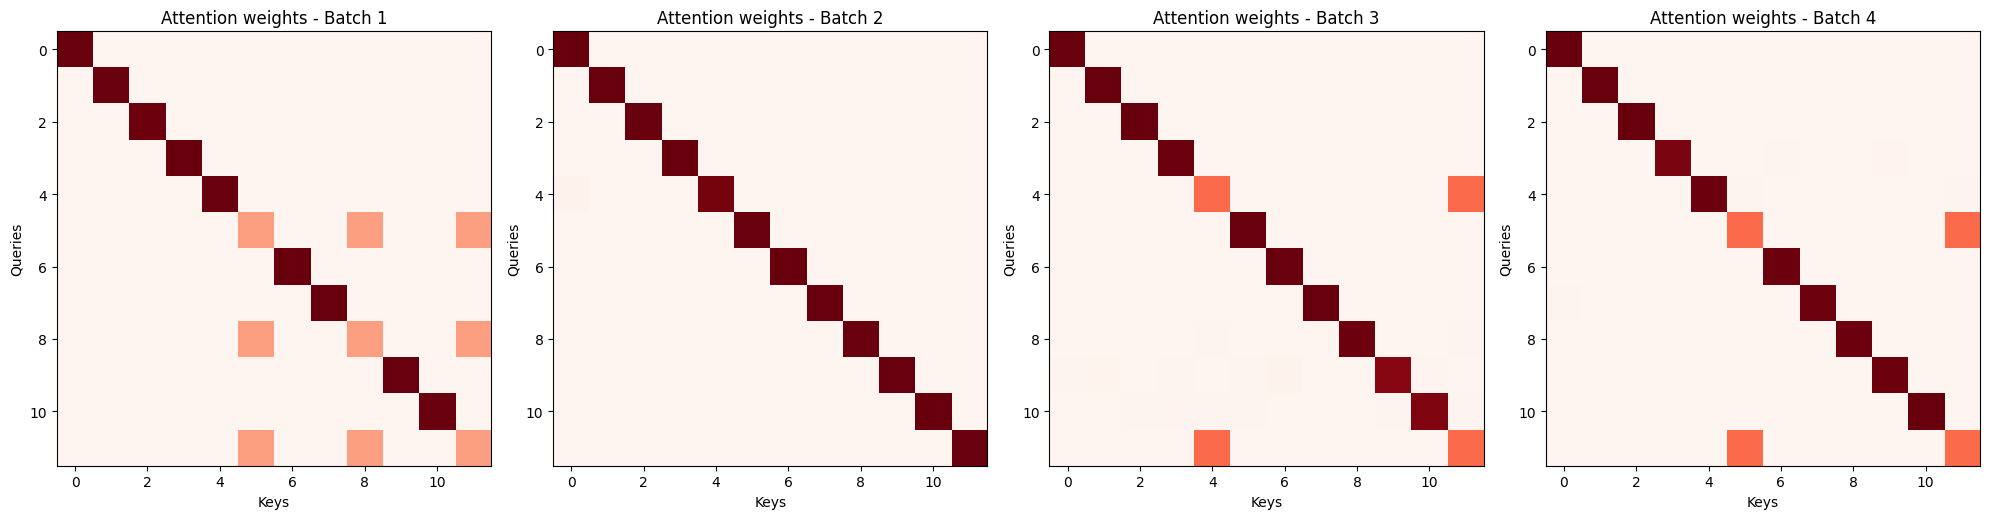

In [16]:
show_attention_batch(attention)

## 使用卷积来替换注意力

很简单的思想，我们计算注意力的时候其实是计算点乘，然后再softmax，这个过程完全可以用卷积来替换

- 我们的句子如果是这样的形状 [batch_size, seq_len, embed_dim]
- 那我们就可以转换成 [batch_size, embed_dim, 1, seq_len]
  - 对应于卷积的输入 [batch_size, in_channels = embed_dim, H = 1, W = seq_len]
  - 卷积核的形状是 [out_channels = seq_len, in_channels = embed_dim, Hk = 1, Wk = 1]
  - 卷积之后的输出为 [batch_size, out_channels = seq_len, H = 1, W= seq_len]
    - 把H squeeze掉，就是 [batch_size, seq_len, seq_len]
    - 正好就是注意力的输出（softmax之前的点乘结果）

In [17]:
word_embed_batch.shape

torch.Size([4, 12, 64])

In [18]:
class ConvSeq(nn.Module):
    def __init__(self, embed_dim, words_length, batch_size):
        super(ConvSeq, self).__init__()
        self.conv = nn.Conv2d(embed_dim, batch_size * words_length, 1, bias=False)
        self.layernorm = nn.LayerNorm([embed_dim, 1, 1])

    def forward(self, x):
        self.conv.weight.data = self.layernorm(rearrange(x, 'b l d -> (b l) d 1 1'))
        x = rearrange(x, 'b l d -> d 1 (b l)') # batch_size, words_length, embed_dim -> C, H, W
        x = self.conv(x)
        return x
    
model = ConvSeq(embed_dim=64, words_length=12, batch_size=4)
model.conv.weight.shape

torch.Size([48, 64, 1, 1])

In [19]:
output = model(word_embed_batch)
output.shape

torch.Size([48, 1, 48])

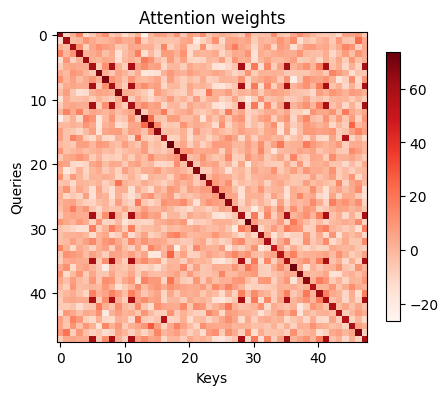

In [20]:
from att2conv import show_attention
show_attention(output.squeeze(1))

In [21]:
attention2 = output.squeeze(1).softmax(dim=-1)

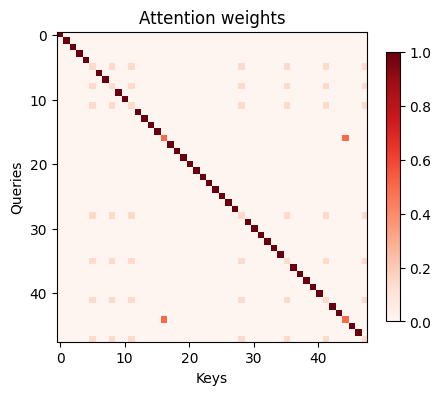

In [22]:
show_attention(attention2)

## 小结

我们这里还计算了batch和batch之间的注意力，但这样的好处是我们可以训练任意长度的数据了，后面可以再思考一下。但我们还是得需要一个batch之间互不相关的版本才行。这里用到的操作就是group convolution。

In [23]:
class ConvSeq2(nn.Module):
    def __init__(self, embed_dim, words_length, batch_size):
        super(ConvSeq2, self).__init__()
        self.conv = nn.Conv2d(embed_dim*batch_size, words_length*batch_size, 1, bias=False, groups=batch_size)
        self.layernorm = nn.LayerNorm([embed_dim, 1, 1])

    def forward(self, x):
        self.conv.weight.data = self.layernorm(rearrange(x, 'b l d -> (b l) d 1 1'))
        x = rearrange(x, 'b l d -> (b d) 1 l') # batch_size, words_length, embed_dim -> C, H, W
        x = self.conv(x)
        return x
    
model = ConvSeq2(embed_dim=64, words_length=12, batch_size=4)
model.conv.weight.shape

torch.Size([48, 64, 1, 1])

In [24]:
output = model(word_embed_batch)
output.shape

torch.Size([48, 1, 12])

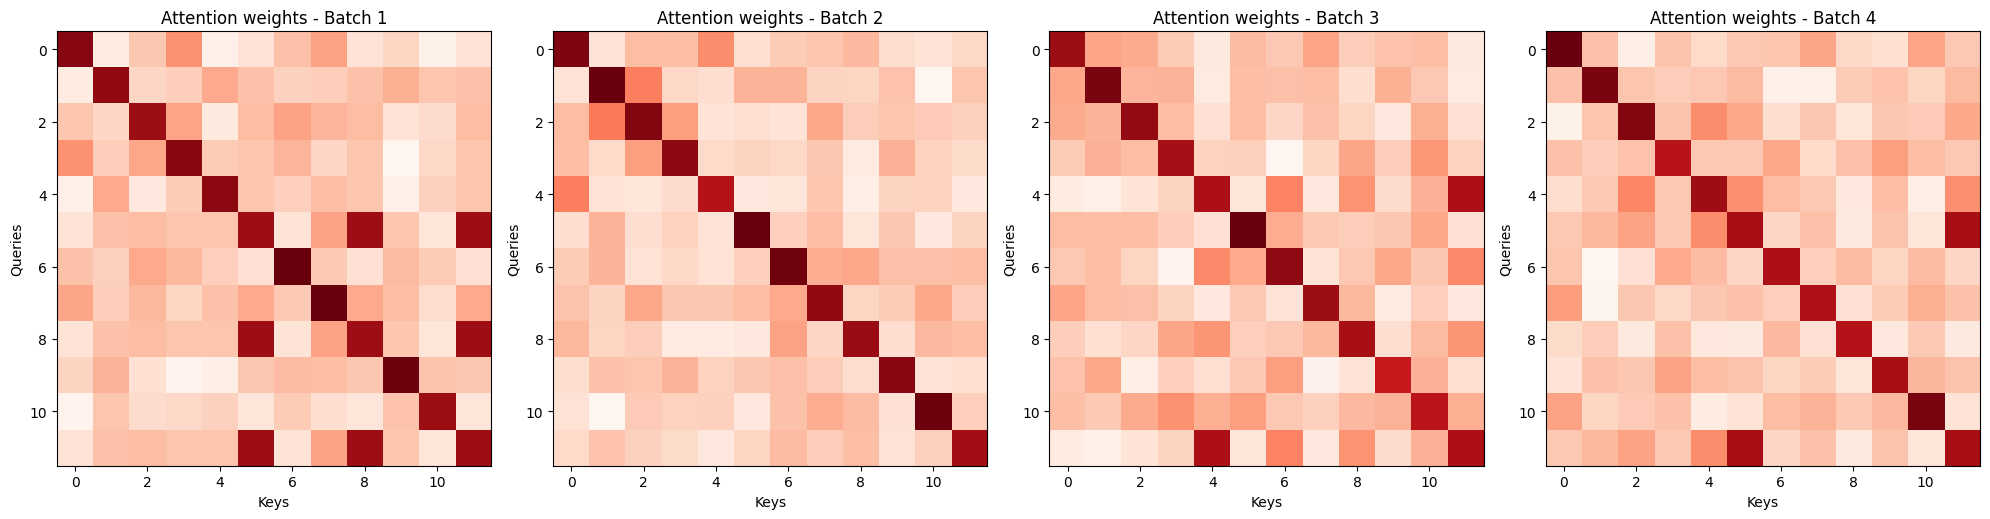

In [25]:
show_attention_batch(rearrange(output, '(b l1) 1 l2 -> b l1 l2', b = 4))

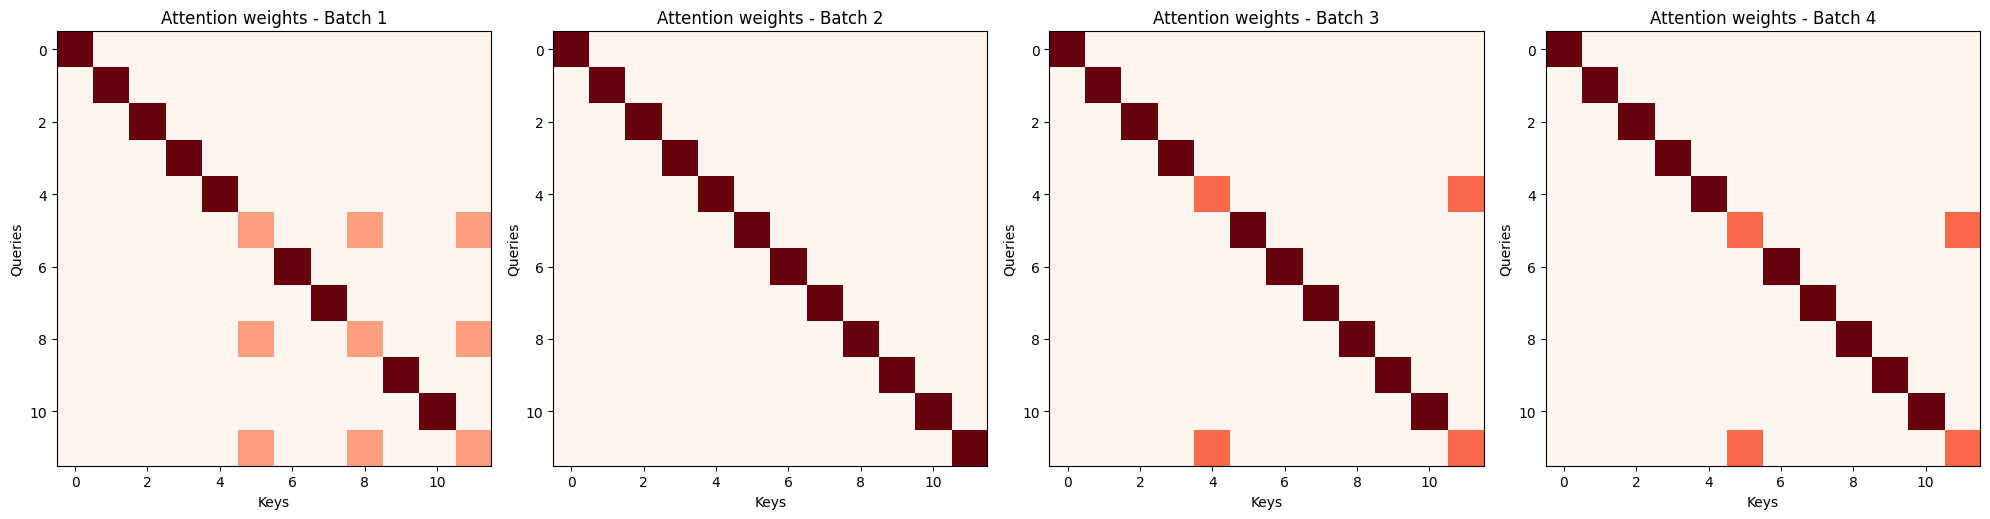

In [26]:
show_attention_batch(
    rearrange(
        output.softmax(dim=-1), 
        '(b l1) 1 l2 -> b l1 l2', 
        b = 4
    )   
)